In [1]:
import sys
import numpy as np
import scipy
import torch
import h5py
import wandb
from configmypy import ConfigPipeline, YamlConfig, ArgparseConfig
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.nn.functional as F

from neuralop import H1Loss, LpLoss, BurgersEqnLoss, ICLoss, WeightedSumLoss, Trainer, get_model
from neuralop.data.transforms.data_processors import MGPatchingDataProcessor
from neuralop.training import setup, AdamW
from neuralop.utils import get_wandb_api_key, count_model_params
from neuralop.models import FNO

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt


In [3]:
torch.cuda.device_count()

8

In [4]:
# set device to cuda 
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=7)

In [3]:
class TensorDataset(Dataset):
    def __init__(self, x, y, transform_x=None, transform_y=None):
        assert (x.size(0) == y.size(0)), "Size mismatch between tensors"
        self.x = x
        self.y = y
        self.transform_x = transform_x
        self.transform_y = transform_y

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        if self.transform_x is not None:
            x = self.transform_x(x)

        if self.transform_y is not None:
            y = self.transform_y(y)

        return {'x': x, 'y':y}

    def __len__(self):
        return self.x.size(0)

In [4]:
data_fpath = "/scratch/julian/neuralop/KS.mat"
f = h5py.File(data_fpath)
# load as torch object - permute to be in (samples, width, length) format
data = torch.tensor(f['u'][:], dtype = torch.float32)

In [5]:
data.shape

torch.Size([512, 2000, 1200])

In [6]:
data[:, 99:1999, :50].shape

torch.Size([512, 1900, 50])

In [7]:
npoints = 50
Xtrain = data[:, 99:1999, :npoints].flatten(1, -1).unsqueeze(1).permute(2, 1, 0)
ytrain = data[:, 100:2000, :npoints].flatten(1, -1).unsqueeze(1).permute(2, 1, 0)

Xtest = data[:, 99:1999, npoints:].flatten(1, -1).unsqueeze(1).permute(2, 1, 0)
ytest = data[:, 100:2000, npoints:].flatten(1, -1).unsqueeze(1).permute(2, 1, 0)

In [9]:
Xtrain.shape

torch.Size([95000, 1, 512])

In [55]:
# train_loader = DataLoader(torch.utils.data.TensorDataset(Xtrain, ytrain), batch_size=32, shuffle=True)
# test_loader = DataLoader(torch.utils.data.TensorDataset(Xtest, ytest), batch_size=32, shuffle=False)

In [8]:
# Define training dataset
train_dataset = TensorDataset(
    x=Xtrain,
    y=ytrain,
    transform_x=None,
    transform_y=None
)

# Define testing dataset
test_dataset = TensorDataset(
    x=Xtest,
    y=ytest,
    transform_x=None,
    transform_y=None
)

# Create DataLoaders
batch_size = 256
train_loader_ks = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader_ks = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [ ]:
import importlib
import neuralop.training  # Import the full module first
importlib.reload(neuralop.training)  # Reload the module

from neuralop.training import Trainer  # Re-import the Trainer class


operator = FNO(n_modes=[64], hidden_channels  = 64, 
               in_channels = 1, out_channels = 1)
print("Number of model parameters: ", count_model_params(operator))

operator = operator.to(device)

trainer = Trainer(model = operator,
                  n_epochs=2,
                  device=device,
                  verbose=True)

optimizer = AdamW(operator.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


test_loaders = {512: test_loader_ks}
trainer.train(train_loader = train_loader_ks, 
              test_loaders = test_loaders, 
              optimizer = optimizer, 
              scheduler = scheduler,
              save_every=1, 
              save_dir="./checkpoints")

Number of model parameters:  1132097
Training on 95000 samples
Testing on [2185000] samples         on resolutions [512].
Training on epoch 0...
torch.Size([512]) [[0.0, 1.0]]
Raw outputs of shape torch.Size([256, 1, 512])
[0] time=6.23, avg_loss=0.0614, train_err=15.6792
Eval: 512_l2=0.0182
[Rank 0]: saved training state to ./checkpoints
Training on epoch 1...
[1] time=5.65, avg_loss=0.0123, train_err=3.1489
Eval: 512_l2=0.0169
[Rank 0]: saved training state to ./checkpoints


{'train_err': 3.1488971597244664,
 'avg_loss': 0.012330418351763173,
 'avg_lasso_loss': None,
 'epoch_train_time': 5.650593301281333,
 '512_l2': tensor(0.0169, device='cuda:0')}

In [38]:
operator

FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 33]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 1, kernel_size=

In [25]:
torch.save(operator, "fno_ks.pth")

In [29]:
test_load_model = torch.load("fno_ks.pth")

test_load_model.eval()

test_load_model.to(device)

/tmp/ipykernel_1600200/2254537179.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_load_model = torch.load("fno_ks.pth")


FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 33]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(2, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 1, kernel_size=

In [39]:
# load saved model from pickle file
test = torch.load("./checkpoints/model_state_dict.pt")

/tmp/ipykernel_1600200/709402954.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test = torch.load("./checkpoints/model_state_dict.pt")


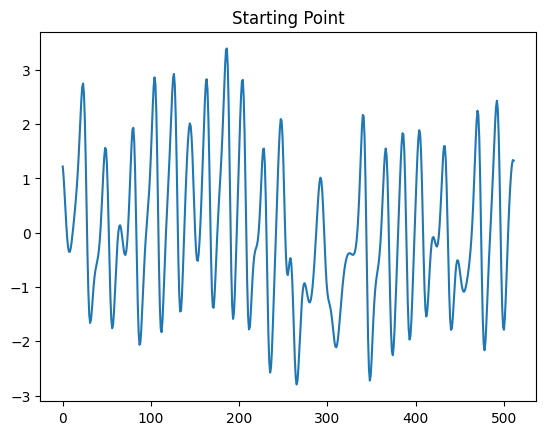

In [31]:
sample = data[:, :, 0]
sample_preds = sample.clone()
plt.plot(sample_preds[:, 300])
plt.title("Starting Point");

In [ ]:
for i in range(500, 1999):
    sample_preds[:, i+1] = test_load_model(sample_preds[:, i].unsqueeze(0).unsqueeze(0).to(device))

TypeError: 'collections.OrderedDict' object is not callable

tensor(1.7397e-09)
tensor(-0.0203, grad_fn=<MeanBackward0>)


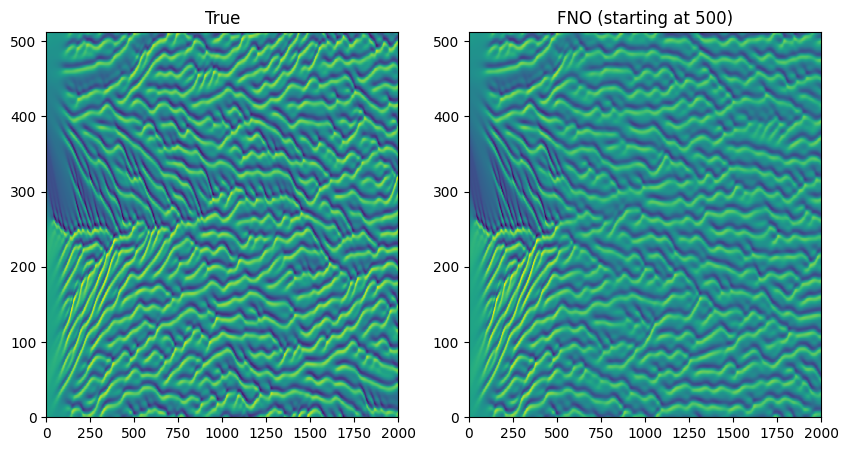

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].pcolormesh(sample)
ax[0].set_title("True")
ax[1].pcolormesh(sample_preds.detach().numpy())
ax[1].set_title("FNO (starting at 500)")
print(torch.mean(sample))
print(torch.mean(sample_preds))

In [78]:
# operator(Xtrain[:2, :, :].to(device))
torch.mean(sample)

tensor(1.7397e-09)

In [ ]:
# get data and visualize errors 
operator = FNO(n_modes=[64], hidden_channels  = 64, 
               in_channels = 1, out_channels = 1)
print("Number of model parameters: ", count_model_params(operator))

operator = operator.to(device)

trainer = Trainer(model = operator,
                  n_epochs=2,
                  device=device,
                  verbose=True)

trainer.

torch.Size([]) [[0.0, 1.0]]


AssertionError: Error: inputs must have same number of dimensions

In [92]:
train_loader.dataset.x.shape

torch.Size([1000, 1, 16, 16])

In [90]:
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.layers.embeddings import GridEmbedding2D


train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=1000, batch_size=32,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='tucker',
             rank=0.42)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')


optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

trainer = Trainer(model=model, n_epochs=20,
                  device="cpu",
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders={},
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              save_every=1,
              save_dir="./checkpoints")

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 

Our model has 520761 parameters.
Training on 1000 samples
Testing on [] samples         on resolutions [].


Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=3.32, avg_loss=0.6785, train_err=21.2042
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[3] time=3.12, avg_loss=0.2296, train_err=7.1751
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[6] time=3.13, avg_loss=0.1868, train_err=5.8363
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[9] time=3.10, avg_loss=0.1553, train_err=4.8540
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoints
[12] time=3.11, avg_loss=0.1567, train_err=4.8958
Eval: 
[Rank 0]: saved training state to ./checkpoints
[Rank 0]: saved training state to ./checkpoin

{'train_err': 4.501665137708187,
 'avg_loss': 0.14405328440666199,
 'avg_lasso_loss': None,
 'epoch_train_time': 3.1106539759784937}

In [ ]:
for res, test_loader in test_loaders.items():
    print(res)
    # Get first batch
    batch = next(iter(test_loader))
    x = batch['x']
    y = batch['y']

    print(f'Testing samples for res {res} have shape {x.shape[1:]}')

16
Testing samples for res 16 have shape torch.Size([1, 16, 16])
32
Testing samples for res 32 have shape torch.Size([1, 32, 32])


In [ ]:
data= train_dataset[0]
x = data["x"]
y = data["y"]

torch.Size([1, 16, 16])

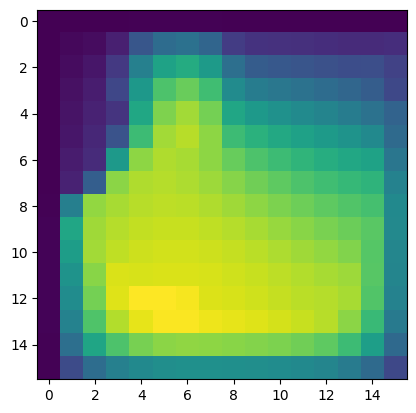

In [81]:
import matplotlib.pyplot as plt
plt.imshow(y[0, :, :])

# Generate Observational Data

In [53]:
from jax_models import *
from KS_solver import KS_step
import numpy as np 
import matplotlib.pyplot as plt


T = 2000  # total simulation time
# t = 500  # time steps
l = 2 * np.pi * 32  # domain length
dt = .25#T/t  # time step size

modes = 20
width = 512

# Initialize Kuramoto-Sivashinsky solver
KS = KuramotoSivashinsky(dt=dt, s=width, l=l, M=modes)

# dt = 1
# s = 512
# l=128
# M=16
# KS = KuramotoSivashinsky(dt=dt, s=s, l=l, M=M)

def f_rand(L):
    nwaves = 5
    a = np.arange(nwaves)+1
    b = np.random.rand(nwaves)
    d = np.random.rand(nwaves)

    xi = np.linspace(0,L,1000)
    fx = xi*0
    for i in range(nwaves):
        fx = fx + b[i]*np.sin(2*a[i]*np.pi*(xi-d[i])/L)
        
    mina = np.min(fx)
    maxa = np.max(fx)


    def f(x):
        fx = x*0
        for i in range(nwaves):
            fx = fx + b[i]*np.sin(2*a[i]*np.pi*(x-d[i])/L)
            
        fx = (fx - mina) / (maxa - mina)  

        # compute the mean evaluated at 1000 points 
        mean_fx = np.trapz(fx, np.linspace(0, L, len(fx))) / L

        # center around 0 for zero average energy
        fx = fx - mean_fx 
        return fx

    return f

t = KS_step(KS, T, f_rand(.1)(np.linspace(0, l, width)))

/tmp/ipykernel_302989/870984879.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_fx = np.trapz(fx, np.linspace(0, L, len(fx))) / L


In [54]:
np.mean(t)

np.float64(-4.880514626767029e-05)

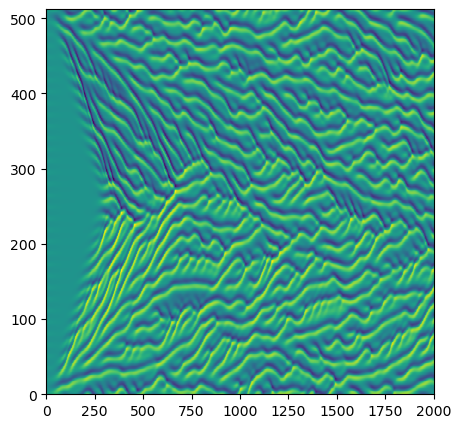

In [55]:
# plt.imshow(np.transpose(t))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.pcolormesh(np.transpose(t))

In [ ]:
# generate data 
n_samples = 1200
n_points = 512
l = 2 * np.pi * 32  # domain length
dt = .25  # time step size
modes = 20
T = 2000  # total simulation time
data = np.zeros((n_samples, T, n_points))

# initialize KS
KS = KuramotoSivashinsky(dt=dt, s=width, l=l, M=modes)

for i in range(n_samples):
    # run KS for n-1 steps (accounting for the initial condition)
    data[i] = KS_step(KS, T-1, f_rand(.1)(np.linspace(0, l, width)))


/tmp/ipykernel_302989/870984879.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_fx = np.trapz(fx, np.linspace(0, L, len(fx))) / L


In [63]:
# save data as torch object 
import torch
torch.save(torch.tensor(data), f"/scratch/julian/neuralop/pygen_{n_samples}_{n_points}_{T}_{modes}_{l:.2f}.pth")

In [ ]:
test_data = torch.load(f"/scratch/julian/neuralop/pygen_{n_samples}_{n_points}_{T}_{modes}_{l:.2f}.pth")
test_data.

torch.Size([1200, 2000, 512])

In [ ]:
# load model 

model = torch.load("/scratch/julian/neuralop/ks_models/pygen_1200_512_2000_20_201.06_debug.pth")
model


ModuleNotFoundError: No module named 'neuralop'